# ZERO NORMALIZED CROSS CORRELATION BETWEEN TWO IMAGES

- change `DATA_PTH` to point to your main processing output folder
- change `REG_DIR` to point to the directory where registration output is stored. tifs should be stored there as `0000.tif`

`conda activate torchcu129`

## LOAD DATA

In [1]:
import os
import glob
import tifffile
import numpy as np
import torch

import matplotlib.pyplot as plt
from tqdm import tqdm
from benchmark import local_normalized_cross_correlation, global_normalized_cross_correlation

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microplot import Microimage

plt.close('all')

fixed = '0166' # 20251028 worm001
mov = '0300'

DATA_PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'

# REG_DIR = 'registered'
# REG_DIR = 'wholistic_registered_smooth-0.02_patch-9_dynamic-40'
REG_DIR = 'wholistic_registered_smooth-0.1_patch-5_dynamic-20'

FIXED_PTH = os.path.join(DATA_PTH,REG_DIR,f'{fixed}.tif')
MOV_PTH = os.path.join(DATA_PTH,REG_DIR,f'{mov}.tif')

reg_contents = glob.glob(os.path.join(DATA_PTH,REG_DIR,'*.tif'))

Z, C, H, W = tifffile.imread(reg_contents[0]).shape
T = len(reg_contents)

fixed = tifffile.imread(FIXED_PTH)[:,1,:,:] # ZHW
mov = tifffile.imread(MOV_PTH)[:,1,:,:]


img = np.concat(((fixed[None,:,:,:],mov[None,:,:,:])),axis=0)

In [2]:
print(fixed.shape)
print(mov.shape)

(39, 200, 500)
(39, 200, 500)


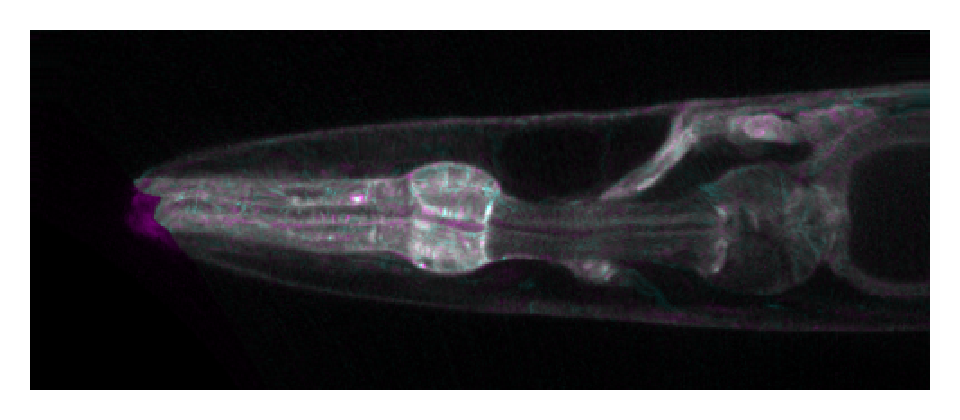

In [ ]:
#plot a single z slice fixed and mov overlay
%matplotlib inline
microshow(
    img[:,13,:,:], cmaps=['pure_magenta','pure_cyan'], flip_map=False, fig_scaling=3, dpi=300,
    rescale_type='limits', limits=[[0,750],[0,750]])

## FORMAT DATA FOR ZNCC

In [4]:
#  cross correlation functions expect torch tensors of shape (B,..)
ref_t = torch.from_numpy(fixed)[None, :, :, :]   # (1, Z, H_ref, W_ref)
mov_t = torch.from_numpy(mov)[None, :, :, :]   # (1, Z, H_t, W_t)
print(ref_t.shape)
print(mov_t.shape)

torch.Size([1, 39, 200, 500])
torch.Size([1, 39, 200, 500])


## GLOCAL ZNCC

In [5]:
zncc = global_normalized_cross_correlation(
    ref_t,
    mov_t,
)

zncc = zncc.squeeze().cpu().numpy()

zncc


array(0.9191993, dtype=float32)

## LOCAL ZNCC

In [8]:
zncc = local_normalized_cross_correlation(
    ref_t,
    mov_t,
)

zncc = zncc.squeeze().cpu().numpy()

zncc.shape


(39, 200, 500)

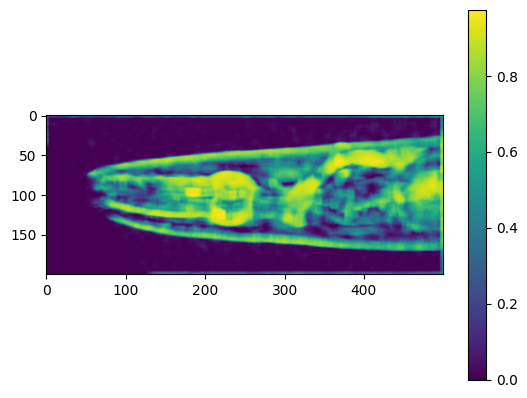

In [16]:
plt.figure()
plt.imshow(np.mean(zncc,axis=0),cmap='viridis')
plt.imshow(zncc[7,:,:],cmap='viridis')
plt.colorbar()
plt.show()

# compare elastix to wholistic

In [35]:
import os
import glob
import tifffile
import numpy as np
import torch

import matplotlib.pyplot as plt
from tqdm import tqdm
from benchmark import local_normalized_cross_correlation, global_normalized_cross_correlation

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microplot import Microimage

plt.close('all')

fixed = '0166' # 20251028 worm001

DATA_PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'

REG_ELX_DIR = 'registered'
FIXED_ELX_PTH = os.path.join(DATA_PTH,REG_ELX_DIR,f'{fixed}.tif')
reg_elx_contents = glob.glob(os.path.join(DATA_PTH,REG_ELX_DIR,'*.tif'))

REG_WHO_DIR = 'wholistic_registered_smooth-0.100_patch-7'
FIXED_WHO_PTH = os.path.join(DATA_PTH,REG_WHO_DIR,f'{fixed}.tif')
reg_who_contents = glob.glob(os.path.join(DATA_PTH,REG_WHO_DIR,'*.tif'))


Z, C, H, W = tifffile.imread(reg_elx_contents[0]).shape
T = len(reg_contents)

T = 242


fixed_elx = tifffile.imread(FIXED_ELX_PTH)[:,1,:,:] # ZHW
fixed_who = tifffile.imread(FIXED_WHO_PTH)[:,1,:,:] # ZHW
zncc_elx = np.zeros((T,1))
zncc_who = np.zeros((T,1))
for i in tqdm(range(T)):
    temp = tifffile.imread(reg_elx_contents[i])[:,1,:,:] # ZHW
    ref_t = torch.from_numpy(fixed_elx)[None, :, :, :]   # (1, Z, H_ref, W_ref)
    mov_t = torch.from_numpy(temp)[None, :, :, :]   # (1, Z, H_t, W_t)

    zncc = global_normalized_cross_correlation(
        ref_t,
        mov_t,
    )

    zncc_elx[i] = np.median(zncc.squeeze().cpu().numpy())

    temp = tifffile.imread(reg_who_contents[i])[:,1,:,:] # ZHW
    ref_t = torch.from_numpy(fixed_who)[None, :, :, :]   # (1, Z, H_ref, W_ref)
    mov_t = torch.from_numpy(temp)[None, :, :, :]   # (1, Z, H_t, W_t)

    zncc = global_normalized_cross_correlation(
        ref_t,
        mov_t,
    )

    zncc_who[i] = np.median(zncc.squeeze().cpu().numpy())

100%|██████████| 242/242 [00:16<00:00, 14.66it/s]


Text(0, 0.5, 'Global ZNCC')

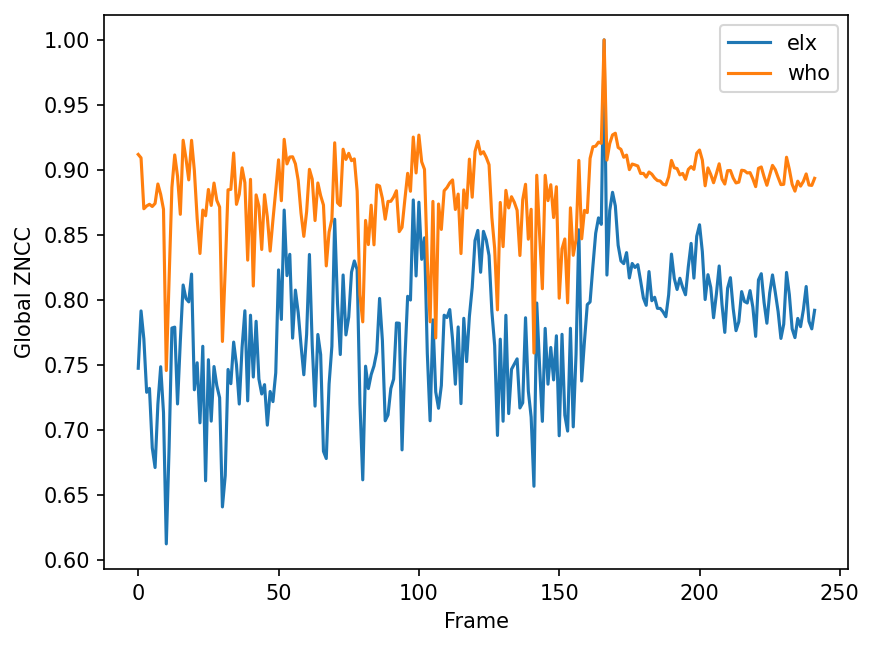

In [36]:
plt.figure(dpi=150)
plt.plot(zncc_elx, label='elx')
plt.plot(zncc_who, label='who')
plt.legend()
plt.xlabel('Frame')
plt.ylabel('Global ZNCC')

In [20]:
fixed.shape

(39, 200, 500)

In [21]:
temp.shape

(39, 200, 500)

In [28]:
np.mean(zncc)

np.float32(0.14366741)

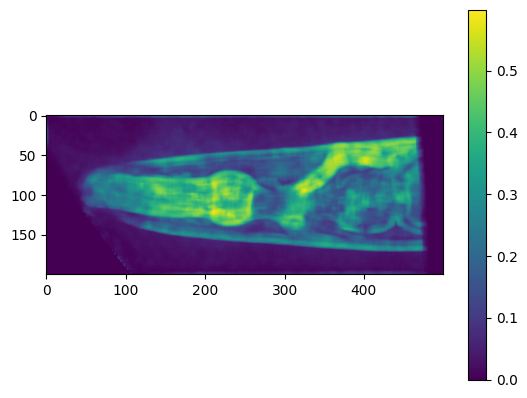

In [26]:
plt.figure()
plt.imshow(np.mean(zncc,axis=0),cmap='viridis')
# plt.imshow(zncc[7,:,:],cmap='viridis')
plt.colorbar()
plt.show()